In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt

from lib.projected_kernel import densities_2_kernel, get_independent_kernel_entries
from lib.exponential_fitting import show_elbow_n, fit_exponential_n

from scipy.stats import iqr

from lib.spread_N_estimation import N_spread, N_spread_noisy, V_k, V_k_noisy
from lib.success_rate_N_estimation import get_N_success_rate_array, get_rho, get_N_success_rate

from tqdm.auto import tqdm

/Users/amiroszewski/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import data

In [2]:
path_2_rdms = 'results/sonar/reduced_density_matrices/full'

files = []
for file in os.listdir(path_2_rdms):
    if file.endswith('.npy'):
        files.append(os.path.join(path_2_rdms, file))
files.sort()

In [3]:
r=6
files_ZZ = [f for f in files if 'ZZ_'+str(r) in f]
print(files_ZZ)

['results/sonar/reduced_density_matrices/full/densities_02_ZZ_6.npy', 'results/sonar/reduced_density_matrices/full/densities_03_ZZ_6.npy', 'results/sonar/reduced_density_matrices/full/densities_04_ZZ_6.npy', 'results/sonar/reduced_density_matrices/full/densities_05_ZZ_6.npy', 'results/sonar/reduced_density_matrices/full/densities_06_ZZ_6.npy', 'results/sonar/reduced_density_matrices/full/densities_07_ZZ_6.npy', 'results/sonar/reduced_density_matrices/full/densities_08_ZZ_6.npy', 'results/sonar/reduced_density_matrices/full/densities_09_ZZ_6.npy', 'results/sonar/reduced_density_matrices/full/densities_10_ZZ_6.npy']


In [4]:
RDMs = []
for f in files_ZZ:
    RDMs.append(np.load(f))

In [5]:
m = RDMs[0].shape[0]

In [6]:
path_2_k = 'results/sonar/projected_entries/full'

files_k = []
for file in os.listdir(path_2_k):
    if file.endswith('.csv'):
        files_k.append(os.path.join(path_2_k, file))
files_k.sort()

In [7]:
files_k

['results/sonar/projected_entries/full/NF_10_ZZ_1.csv',
 'results/sonar/projected_entries/full/NF_10_ZZ_2.csv',
 'results/sonar/projected_entries/full/NF_10_ZZ_3.csv',
 'results/sonar/projected_entries/full/NF_10_ZZ_4.csv',
 'results/sonar/projected_entries/full/NF_10_ZZ_5.csv',
 'results/sonar/projected_entries/full/NF_10_ZZ_6.csv']

In [8]:
files_ZZ_k = [f for f in files_k if 'ZZ_'+str(r) in f]
#ies = np.array([np.load(f) for f in files_ZZ_k])
ies = pd.read_csv(files_ZZ_k[0], header=None).to_numpy()

In [9]:
ies.shape

(9, 21528)

# Kernel entries, error budget

## Kernel concentration

In [10]:
n_range_sim = np.arange(2,2+ies.shape[0])

In [11]:
k_conc = 1-np.median(ies, axis=1)

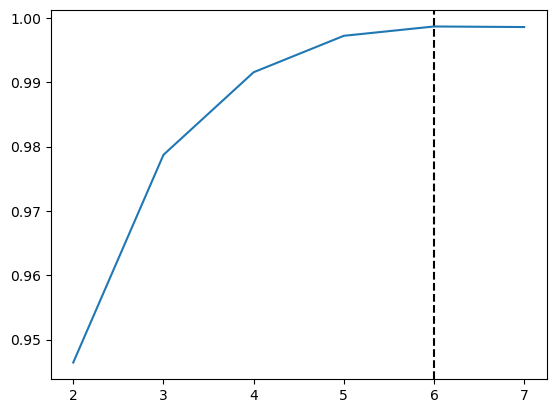

Best qubit score:  0.998651240410212
GOOD fit


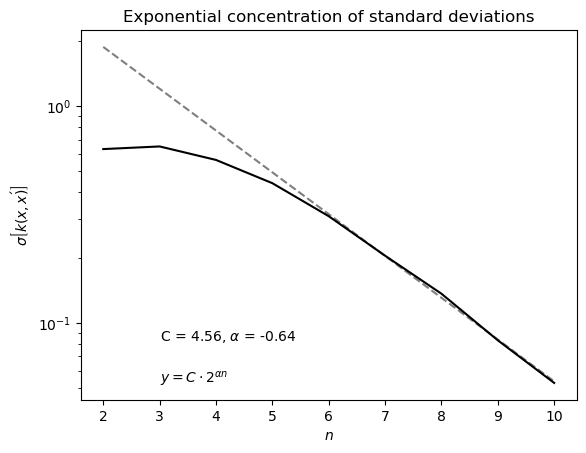

In [12]:
best_qubit = 6
show_elbow_n(k_conc, best_qubit=best_qubit)
alpha_M, C_M = fit_exponential_n(k_conc, best_qubit=best_qubit)

In [13]:
n_range = np.array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  15,  20,  30,  40,
        50,  60,  70,  80,  90, 100])

kappa_extrapolated = C_M*np.power(2, alpha_M *n_range)

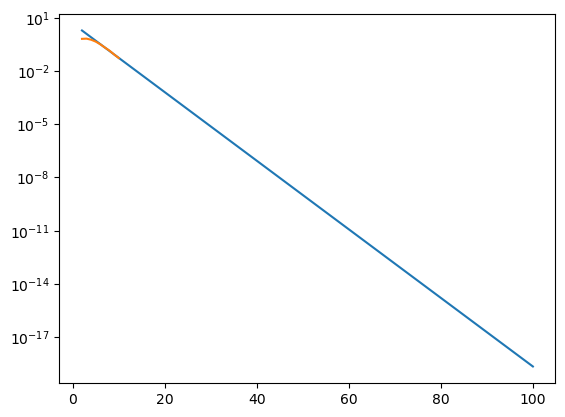

In [14]:
plt.plot(n_range, kappa_extrapolated)
plt.plot(n_range_sim, k_conc)
plt.yscale('log')
plt.show()

## IQR

In [15]:
k_iqr = iqr(ies, axis=1)

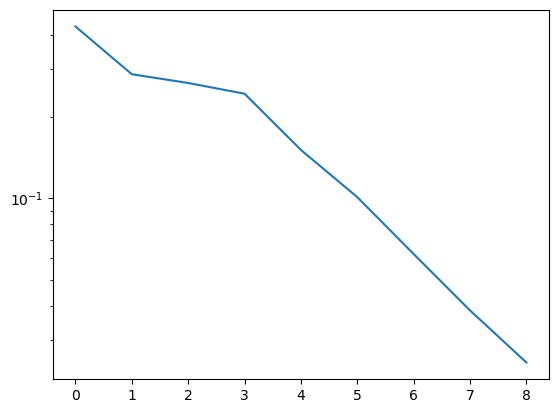

In [16]:
plt.plot(k_iqr)
plt.yscale('log')

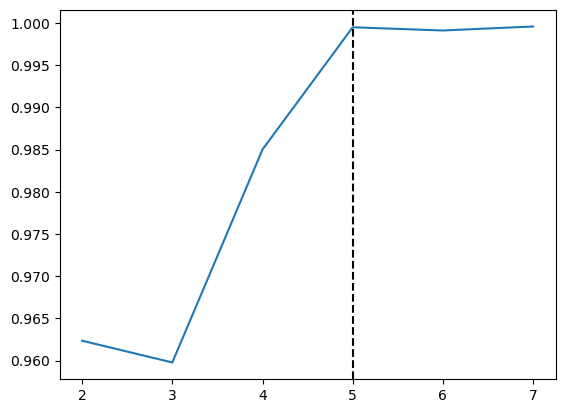

Best qubit score:  0.9994849297286643
GOOD fit


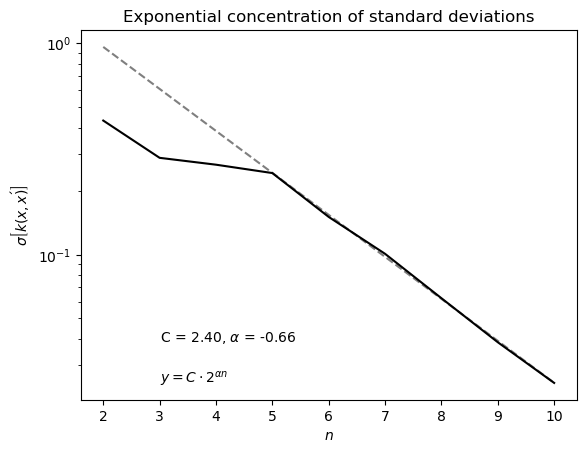

In [17]:
best_qubit = 5
show_elbow_n(k_iqr, best_qubit = best_qubit)
alpha_iqr, C_iqr = fit_exponential_n(k_iqr, best_qubit=best_qubit)

In [18]:
iqrs = C_iqr*np.power(2,alpha_iqr*n_range)

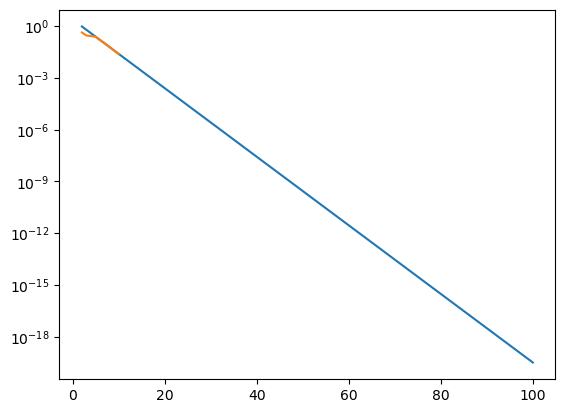

In [19]:
plt.plot(n_range, iqrs)
plt.plot(n_range_sim, k_iqr)
plt.yscale('log')
plt.show()

## Error budget

In [20]:
def error_budget(Delta, Kappa):
    """ 
    p <= Delta/( 4 | 1-Kappa | )
    """
    p = Delta/(4*np.abs(1-Kappa))
    return(p)

def error_budget_app(Delta, Kappa):
    """
    p <= Delta/( 4 Kappa ln(Kappa) )
    """
    p = -Delta/(4*Kappa*np.log(Kappa))
    return(p)

In [21]:
error_extrapolated = error_budget_app(iqrs, 1-kappa_extrapolated)
error_simulated = error_budget_app(k_iqr, 1-k_conc)
error_extrapolated[:9] = error_simulated
error_extrapolated

/var/folders/3c/ljwwm7tx1h3_05wq1m93d6mr0000gn/T/ipykernel_81710/3410864599.py:12: RuntimeWarning: invalid value encountered in log
  p = -Delta/(4*Kappa*np.log(Kappa))
/var/folders/3c/ljwwm7tx1h3_05wq1m93d6mr0000gn/T/ipykernel_81710/3410864599.py:12: RuntimeWarning: divide by zero encountered in true_divide
  p = -Delta/(4*Kappa*np.log(Kappa))


array([0.29320657, 0.19559067, 0.18419927, 0.18727427, 0.14724843,
       0.1390291 , 0.12305601, 0.12121451, 0.12042082, 0.10827649,
       0.10105796, 0.08846402, 0.07746339, 0.06783095, 0.05939615,
       0.05201691, 0.04535151,       -inf,       -inf])

# Input from the Azure QRE

In [22]:
# Your new DataFrame
data = {
    'n': [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0],
    'error_budget': [0.293207, 0.195591, 0.184199, 0.187274, 0.147248, 0.139029, 0.123056, 0.121215, 0.120421, 0.108276, 0.101058, 0.088464, 0.077463, 0.067831, 0.059396, 0.052017, 0.045352],
    'physical_qubits': [34450.0, 25176.0, 87710.0, 99764.0, 115640.0, 105646.0, 237330.0, 257256.0, 283500.0, 369684.0, 382428.0, 860794.0, 1020998.0, 1582178.0, 1765374.0, 1880970.0, 1969526.0],
    'physical_qubits_STD': [0.0] * 17,
    'runtime': [234000.0, 652400.0, 952000.0, 1209600.0, 1587600.0, 2430000.0, 2836800.0, 3261600.0, 3927600.0, 6519600.0, 12223200.0, 21573200.0, 34188000.0, 56966000.0, 78010400.0, 100084400.0, 124758400.0],
    'runtime_STD': [0.0] * 17
}

df = pd.DataFrame(data)

# Save DataFrame to CSV
df.to_csv('sonar_Azure_6.csv', index=False)

In [23]:
df

,n,error_budget,physical_qubits,physical_qubits_STD,runtime,runtime_STD
0,2.0,0.293207,34450.0,0.0,234000.0,0.0
1,3.0,0.195591,25176.0,0.0,652400.0,0.0
2,4.0,0.184199,87710.0,0.0,952000.0,0.0
3,5.0,0.187274,99764.0,0.0,1209600.0,0.0
4,6.0,0.147248,115640.0,0.0,1587600.0,0.0
5,7.0,0.139029,105646.0,0.0,2430000.0,0.0
6,8.0,0.123056,237330.0,0.0,2836800.0,0.0
7,9.0,0.121215,257256.0,0.0,3261600.0,0.0
8,10.0,0.120421,283500.0,0.0,3927600.0,0.0
9,15.0,0.108276,369684.0,0.0,6519600.0,0.0


# N_spread

In [24]:
P_spread = 0.99

In [29]:
P_target = 0.99

V = np.empty((len(RDMs), int(m*(m-1)/2)))
V_noisy = np.empty((len(RDMs), int(m*(m-1)/2)))

for id in range(len(RDMs)):
    print('id: ', id, ' of: ',len(RDMs)-1)
    RDMs_qubit = RDMs[id]
    Delta = iqrs[id]

    V_qubit = []
    V_noisy_qubit = []
    for i in tqdm(range(RDMs_qubit.shape[0])):
        for j in range(i):
            k_max = RDMs_qubit.shape[1]
            rho_1 = RDMs_qubit[i]
            rho_2 = RDMs_qubit[j]
            V_kk=[]
            V_kk_noisy=[]
            for k in range(k_max):
                V_kk.append(V_k(k, rho_1, rho_2))
                V_kk_noisy.append(V_k_noisy(k, rho_1, rho_2))
            V_qubit.append(np.mean(V_kk))
            V_noisy_qubit.append(np.mean(V_kk_noisy))
    V_qubit = np.array(V_qubit)
    V_noisy_qubit = np.array(V_noisy_qubit)

    V[id] = V_qubit
    V_noisy[id] = V_noisy_qubit

id:  0  of:  8


100%|██████████| 208/208 [00:02<00:00, 100.48it/s]


id:  1  of:  8


100%|██████████| 208/208 [00:02<00:00, 72.40it/s] 


id:  2  of:  8


100%|██████████| 208/208 [00:03<00:00, 57.55it/s]


id:  3  of:  8


100%|██████████| 208/208 [00:04<00:00, 46.94it/s]


id:  4  of:  8


100%|██████████| 208/208 [00:05<00:00, 36.15it/s]


id:  5  of:  8


100%|██████████| 208/208 [00:06<00:00, 32.82it/s]


id:  6  of:  8


100%|██████████| 208/208 [00:06<00:00, 30.17it/s]


id:  7  of:  8


100%|██████████| 208/208 [00:07<00:00, 27.24it/s]


id:  8  of:  8


100%|██████████| 208/208 [00:08<00:00, 23.85it/s]


In [30]:
V_m = np.mean(V,axis=1)
V_m_noisy = np.mean(V_noisy, axis=1)

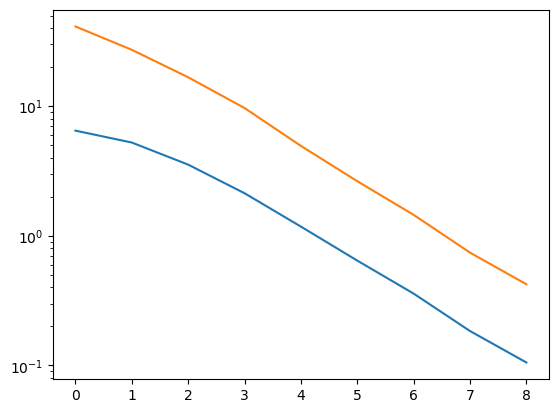

In [31]:
plt.plot(V_m)
plt.plot(V_m_noisy)
plt.yscale('log')
plt.show()

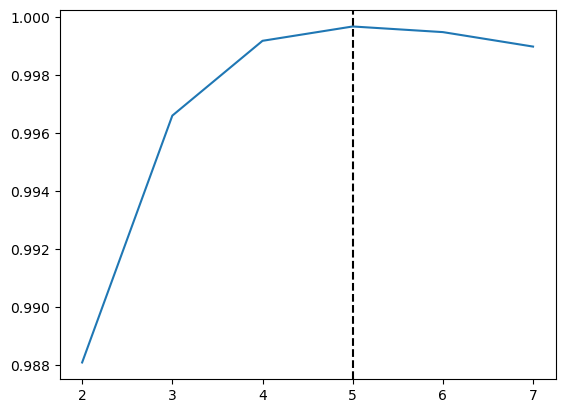

Best qubit score:  0.9996767202810551
GOOD fit


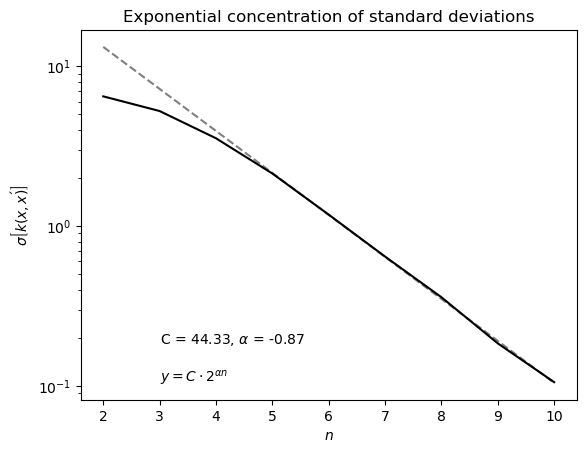

In [32]:
best_qubit = 5
show_elbow_n(V_m, best_qubit=best_qubit)
alpha_Vm, C_Vm = fit_exponential_n(V_m, best_qubit=best_qubit)

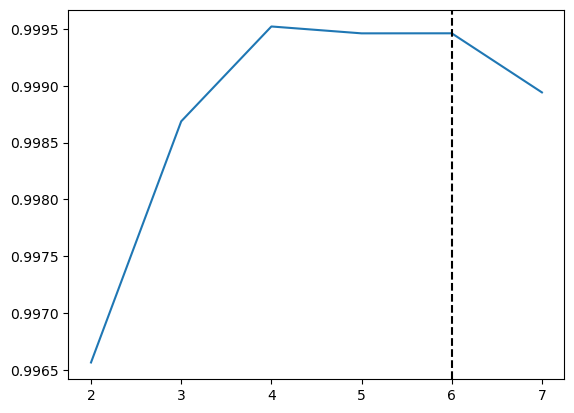

Best qubit score:  0.9994624165636197
GOOD fit


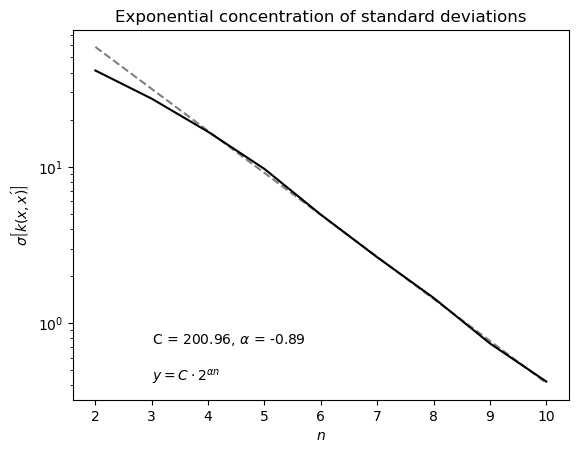

In [33]:
best_qubit=6
show_elbow_n(V_m_noisy, best_qubit=best_qubit)
alpha_Vm_noisy, C_Vm_noisy = fit_exponential_n(V_m_noisy, best_qubit=best_qubit)

In [34]:
V_m_extrapolated = C_Vm*np.power(2,alpha_Vm*n_range)
V_m_noisy_extrapolated = C_Vm_noisy*np.power(2,alpha_Vm_noisy*n_range)

In [35]:
def N_spread_m(n,kappa, Delta_ensemble, V_m, epsilon = 1, P_target=0.99, gamma=1):
    numerator = (gamma**2)*(kappa**2)*(n**2)*V_m#V_m is a mean value of V_k, therefore n*V_m = sum_{k}V_k
    denominator = (1-P_target)*(epsilon**2)*(Delta_ensemble**2)
    return(numerator/denominator)

### Noiseless

In [36]:
N_s_sim = []

for i in range(k_conc.shape[0]):
    n = n_range[i]
    N_s_sim.append(N_spread_m(n=n,kappa=1-k_conc[i], Delta_ensemble=iqrs[i], V_m=V_m[i]))

N_s_sim = np.array(N_s_sim)

In [37]:
N_s_ext = []

for i in range(n_range.shape[0]):
    n = n_range[i]
    N_s_ext.append(N_spread_m(n=n,kappa=1-kappa_extrapolated[i], Delta_ensemble=iqrs[i], V_m=V_m_extrapolated[i]))

N_s_ext = np.array(N_s_ext)

In [38]:
N_s_ext[:N_s_sim.shape[0]]=N_s_sim

In [39]:
df_N_S = pd.DataFrame({'n':n_range,'N_spread':N_s_ext})
df_N_S.to_csv('results/N_estimates/N_spread_PQ_sonar_ZZ6.csv')
df_N_S

,n,N_spread
0,2,3.762492e+02
1,3,1.547201e+03
2,4,7.241331e+03
3,5,2.801863e+04
4,6,8.472453e+04
5,7,2.097366e+05
6,8,4.482635e+05
7,9,8.213944e+05
8,10,1.545647e+06
9,15,1.785599e+07


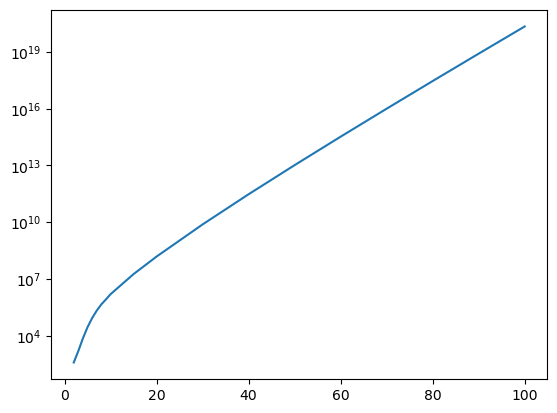

In [40]:
plt.plot(n_range,N_s_ext)
plt.yscale('log')
plt.show()

### Noisy

In [41]:
N_s_sim_noisy = []

for i in range(k_conc.shape[0]):
    n = n_range[i]
    N_s_sim_noisy.append(N_spread_m(n=n,kappa=1-k_conc[i], Delta_ensemble=iqrs[i], V_m=V_m_noisy[i]))

N_s_sim_noisy = np.array(N_s_sim_noisy)

In [42]:
N_s_ext_noisy = []

for i in range(n_range.shape[0]):
    n = n_range[i]
    N_s_ext_noisy.append(N_spread_m(n=n,kappa=1-kappa_extrapolated[i], Delta_ensemble=iqrs[i], V_m=V_m_noisy_extrapolated[i]))

N_s_ext_noisy = np.array(N_s_ext_noisy)

In [43]:
N_s_ext_noisy[:N_s_sim_noisy.shape[0]]=N_s_sim_noisy

In [44]:
df_N_S_noisy = pd.DataFrame({'n':n_range,'N_spread_noisy':N_s_ext_noisy})
df_N_S_noisy.to_csv('results/N_estimates/N_spread_PQ_sonar_ZZ6_noisy.csv')
df_N_S_noisy

,n,N_spread_noisy
0,2,2.393887e+03
1,3,8.032161e+03
2,4,3.418584e+04
3,5,1.272788e+05
4,6,3.552197e+05
5,7,8.594929e+05
6,8,1.816163e+06
7,9,3.306480e+06
8,10,6.205576e+06
9,15,6.653584e+07


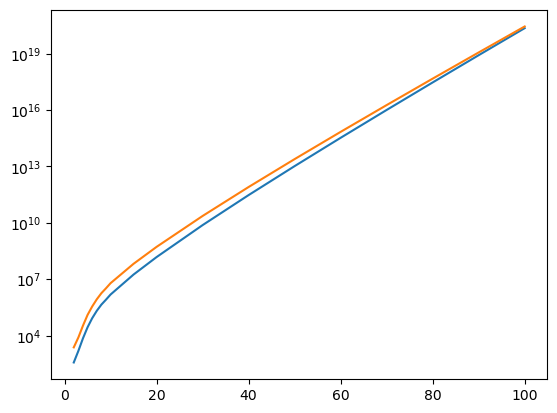

In [45]:
plt.plot(n_range,N_s_ext)
plt.plot(n_range,N_s_ext_noisy)
plt.yscale('log')

# Concentration avoidance

In [46]:
def ies_2_kernel_matrix(ies, m=208):
    K = np.zeros((m,m))
    K[np.triu_indices(m,k=1)]=ies
    K += K.T
    K = K + np.identity(m)
    return(K)

def epsilon_CA(K, n, gamma=1):
    constant = -1/(12*gamma*n)
    logs = np.log(K).mean()
    epsilon_CA = np.sqrt(constant*logs)
    return(epsilon_CA)

def N_CA_approx(epsilon,z=2.326,mu=0.5):
    N_CA = ((z**2)*mu*(1-mu))/(epsilon**2)
    return(N_CA)

def ies_2_N_CA_approx(ies, n, m=208, z=2.326, gamma=1):
    K = ies_2_kernel_matrix(ies,m=m)
    eps = epsilon_CA(K,n, gamma=gamma)
    N_CA = N_CA_approx(eps,z=z)
    return(N_CA)

In [47]:
n_N_CA = np.zeros((ies.shape[0],2))

for i, entries in enumerate(ies):
    n=i+2
    n_N_CA[i,0]=n
    n_N_CA[i,1]=ies_2_N_CA_approx(entries,n)

In [48]:
n_N_CA

array([[2.00000000e+00, 2.81911013e+01],
       [3.00000000e+00, 4.33288439e+01],
       [4.00000000e+00, 6.91889665e+01],
       [5.00000000e+00, 1.16028403e+02],
       [6.00000000e+00, 2.37891229e+02],
       [7.00000000e+00, 4.45814434e+02],
       [8.00000000e+00, 8.18591547e+02],
       [9.00000000e+00, 1.59534335e+03],
       [1.00000000e+01, 2.79827279e+03]])

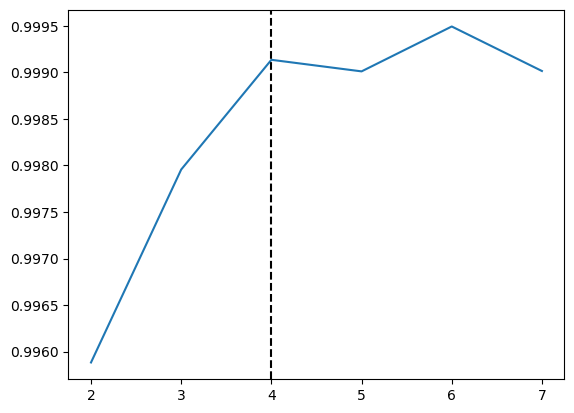

Best qubit score:  0.9991341139677216
GOOD fit


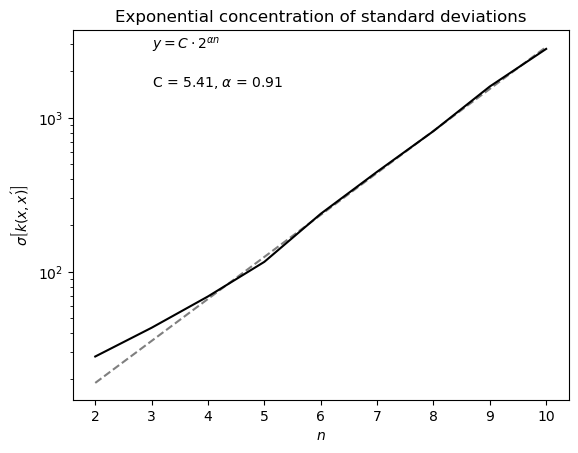

In [49]:
best_qubit=4
show_elbow_n(n_N_CA[:,1], best_qubit=best_qubit)
alpha_N_CA, C_N_CA = fit_exponential_n(n_N_CA[:,1], best_qubit=best_qubit)

In [50]:
N_CA = C_N_CA*np.power(2,alpha_N_CA*df['n'].to_numpy())
df_N_CA = pd.DataFrame({'n':df['n'].to_numpy(),'N_CA':N_CA})
df_N_CA.to_csv('results/N_estimates/N_CA_PQ_sonar_ZZ6.csv')

In [51]:
df_N_CA

,n,N_CA
0,2.0,1.899616e+01
1,3.0,3.558791e+01
2,4.0,6.667134e+01
3,5.0,1.249039e+02
4,6.0,2.339982e+02
5,7.0,4.383786e+02
6,8.0,8.212701e+02
7,9.0,1.538589e+03
8,10.0,2.882435e+03
9,15.0,6.651860e+04


# Together

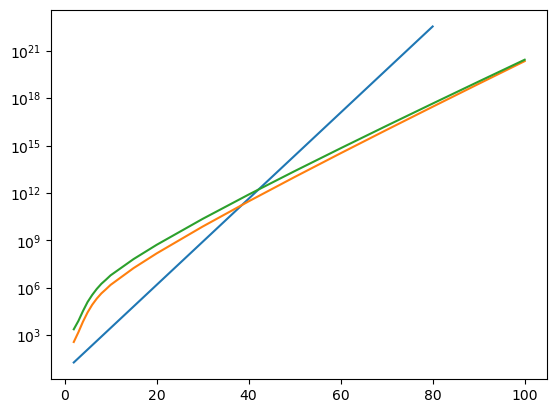

In [52]:
plt.plot(n_range[:-2], N_CA)
plt.plot(n_range, N_s_ext)
plt.plot(n_range, N_s_ext_noisy)
plt.yscale('log')
plt.show()